In [1]:
# %matplotlib qt5
%matplotlib inline
import numpy as np
from numpy import linalg as la
import matplotlib.pylab as plt
from scipy.optimize import fsolve
import math
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from Meanfield_Dyn_util import *


In [2]:
### dynamics
def iidGaussian(stats,shapem):
	mu,sig = stats[0],stats[1]
	nx,ny = shapem[0],shapem[1]
	return np.random.normal(mu,sig,(nx,ny))

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d
def equations(x,data):
    '''
    Function: compute the largest real eigenvalue outlier of the matrix with chain motifs
    eqleft = (outlier**2+gaverage**2*tau)*(outlier**2-gaverage**2*tau*(N-1))
    eqright = outlier*eigvAm[0]*(outlier**2-gaverage**2*tau*(N-1))+gaverage**2*tau*eigvAm[0]*N
    f(outlier) = eqleft - eqright = 0
    params:
    data = [g, tau_chn, lambda_0, N]
    '''
    outlier = x
    gaverage,tau,eigvAm,N = data[0],data[1],data[2],data[3]
    eqleft = (outlier**2+gaverage**2*tau)*(outlier**2-gaverage**2*tau*(N-1))
    eqright = outlier*eigvAm*(outlier**2-gaverage**2*tau*(N-1))+gaverage**2*tau*eigvAm*outlier*N
    # eqright = outlier*eigvAm*(outlier**2+gaverage**2*tau)
    
    return (eqleft-eqright)
#### compute corresponding parameters and variables in the equivalent sparse networks
### Epopulation
def compute_AdjacencyParams(x,JE,JI,sigmae,sigmai,Nparams):
    ce,ci = x[0],x[1]
    NE,NI = Nparams[0],Nparams[1]
    J = JE/NE/ce 
    g = JI/NI/ci/J 
    
    sigmae2 = J**2*ce*(1-ce)*N 
    sigmai2 = g**2*J**2*ci*(1-ci)*N 
    
    resultse = sigmae**2-sigmae2
    resultsi = sigmai**2-sigmai2
    return np.array([resultse,resultsi])

In [3]:
import scipy
from functools import partial
def odeIntegral(x,t,J,I=0):
    x = np.squeeze(x)
    x = np.reshape(x,(len(x),1))
    # dxdt = -x+J@np.tanh(x)#+I[0]
    dxdt = -x+J@(x)+I[0]
    return np.squeeze(dxdt)
def odesimulation(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegral,J=Jpt,I=I),xinit,t)

#### Network with Gaussian-distributed synaptic weights

In [4]:
nn = [50,100,150,250,750,500,800]
NE, NI = nn[-1], nn[-1] 
gamma = 1/4
NI = int(NE*gamma)
N = NE+NI
JE, JI = 0.65, 1.65#1.5, 2.0
Nparams = np.array([NE,NI])
J_0 = JE/NE # tablet J0 = 8.125*1e-4
g_i2e = JI/NI/J_0 # tablet g = 10.15
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 

g_max,tau_max = 0.10,.1
ntau = 11## denser taus
tau_series = np.linspace(0,tau_max,ntau)#np.linspace(0,0.2,ntau)
trials = 30+6 #is the minimal number of iterations
# recordings
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
htau    = tau_series[1]-tau_series[0]

### also record the reconstructed eigenvectors
eigrvec_series_rec, eiglvec_series_rec = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))

### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0] = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])

#### Excitatory input to inhibitory neurons

In [5]:
#### constant and deterministic input signal
Inp   = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
Ipert = np.squeeze(np.ones((N,1)))/np.sqrt(N) 

Ipert[:NE]=0 ### inhibitory input 
# Ipert[NE:]=0 ### excitatory input

#### random and structural input signal 
### simulation using the mean network connectivity (inhibition-dominated)
Jpt   = Jbar.copy()
xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
tt    = np.linspace(0,100,1000)
xtemporal = odesimulation(tt, xinit, Jpt, Inp)
firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1)) ## mean response

In [6]:
### if you want to re-run the simulations
eiglvec0norm_series= np.zeros((trials,ntau,N,2))
leig0mean_series = np.zeros((trials,ntau,N,2))
leig0pre_series = np.zeros((trials,ntau,N,2))
### simulation using the low-rank framework
firing_rateeq = np.zeros((trials,ntau,N))
firing_ratepert = np.zeros((trials,ntau,N))

gaverage = g_max ### set the magnitude of the connectivity fluctuation
switch = 1

for ktrial in range(trials):
    xr      = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
    chneta  = iidGaussian([0,gaverage/np.sqrt(N)],[N,6])
    xrec    = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
    ### zscore
    xr   = stats.zscore(xr.flatten())
    xr   = xr*gaverage/np.sqrt(N)
    xr   = np.reshape(xr,(N,N))
    ### zscore
    xrec = stats.zscore(xrec.flatten())
    xrec = xrec*gaverage/np.sqrt(N)
    xrec = np.reshape(xrec,(N,N))
    ### zscore
    chneta[:,0]  = stats.zscore(chneta[:,0])
    chneta[:,0] *=(gaverage/np.sqrt(N))
    ### ---------------------
    intg_ov = np.zeros(2)
    intg_ml, intg_mr = leigvec0.copy(), reigvec0.copy()
    mean_pre = np.array([JE-JI,0])
    mean_total_change = np.zeros(2)
    z_pre = np.zeros((N,N))
    for it, tau in enumerate(tau_series):
        a    = np.sqrt(np.abs(tau))
        zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
        zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)#a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
        gammarec = a*xrec-a*xrec.copy().T
        # zr   = zrow.copy()+zcol.copy()+np.sqrt(1-4*tau)*xr+gammarec
        zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr
        # zr = xrec*np.sqrt(tau/2)+xrec.copy().T*np.sqrt(tau/2)+np.sqrt(1-tau)*xr ### RECIPROCAL        
        ha    = np.sqrt(htau)
        hzrow = ha*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
        hzcol = ha*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
        hgammarec = ha*xrec-ha*xrec.copy().T
        # hzr   = hzrow.copy()+hzcol.copy()+np.sqrt(1-4*htau)*xr+hgammarec
        hzr   = hzrow.copy()+hzcol.copy()+np.sqrt(1-2*htau)*xr
        DELTA_Z = zr-z_pre
        hzr   = DELTA_Z.copy()
        
        ### generate J connectivity matrix
        Jchn = Jbar.copy()+zr.copy()
        
        '''### full rank simulation'''
        xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
        xc_temporal = odesimulation(tt, xinit, Jchn, Inp)
        firing_rateeq[ktrial,it,:] = xc_temporal[-1,:].copy()
        '''### perturbation '''
        xpert = xc_temporal[-1,:].copy()
        xpert = xpert.reshape(-1,1)
        dtt =tt[1]-tt[0]
        for ttt in range(len(tt)):
            delta_x= -xpert + Jchn@xpert.reshape(-1,1)+Ipert.reshape(-1,1)+Inp.reshape(-1,1)
            xpert = delta_x*dtt+xpert 
        firing_ratepert[ktrial,it,:] = xpert.copy().squeeze()
        
        eigvchn, eigrvec = la.eig(Jchn)
        eigvchn_,eiglvec = la.eig(Jchn.copy().T)
        assert(np.sum(np.abs(eigvchn[0]-eigvchn_[0]))<1e-9)## check the consistency of left and right eigenvectors
        ### normalization
        reig  = np.squeeze(eigrvec[:,:].copy())
        leig0 = np.squeeze(eiglvec[:,:].copy()) 
        normval = np.sum(reig.copy()*leig0.copy(),axis=0)
        norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
        normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
        leig = leig0.copy()/normval.copy()### left eigenvector normalization

        if np.mean(reig[:NE,0])<0:
            reig[:,0]*=-1
            leig[:,0]*=-1
            leig0[:,0]*=-1
        if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
            reig[:,1]*=-1
            leig[:,1]*=-1
            leig0[:,1]*=-1
            
                
        eigvchn_series[ktrial,it,:]    = eigvchn.copy()#eigvw_norm.copy()#
        eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
        eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
        eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
        for iii in range(2):
            eiglvec0norm_series[ktrial,it,:,iii] = leig0[:,iii].copy()/normval[iii,iii]
            
        z_pre = zr.copy()



C:\Users\Administrator\AppData\Local\Temp\ipykernel_43648\3110220812.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43648\3110220812.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43648\3110220812.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43648\3110220812.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43648\3110220812.py:92: Comple

In [21]:
data_name ="E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/19Mar_eigenvectors_corrected/Gaussian_data/DynsStats_Gauss_16April_INParadoxical_normlr.npz"#"E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/19Mar_eigenvectors_corrected/Gaussian_data/DynsStats_Gauss_16April_EXParadoxical_normlr.npz"# 
# np.savez(data_name, **data)
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/19Mar_eigenvectors_corrected/Gaussian_data/DynsStats_Gauss_16April_EXParadoxical_normlr.npz"#DynsStats_Gauss_16April_INParadoxical_normlr.npz"#
### load data  
data = np.load(data_name,allow_pickle=True)
eigvchn_series = data['eigvchn_series']
eigrvec_series = data['eigrvec_series']
eiglvec_series = data['eiglvec_series']
eiglvec0_series = data['eiglvec0_series']
norml0_series = data['norml0_series']
params = data['params']
intg_ov_series = data['intg_ov_series']
first_perturb_ov = data['first_perturb_ov']
first_perturb_ovP = data['first_perturb_ovP']
intg_mean_series = data['intg_mean_series']
intg_std_series = data['intg_std_series']
intg_std_num_series = data['intg_std_num_series']

firing_rateeq = data['firing_rateeq']
firing_ratepert = data['firing_ratepert']

In [7]:
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx#[3:-3]
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [18 13  8  7 31 21 35 14 23  4 30 24 25 12 28 26  0 32 10  1 27  5 34  9
 33 11 29  3  2 17 20 22 19  6 15 16] 36


In [8]:
'''### compute the theoretical eigenvalue outliers and the spectral radius'''
### recording 
gaverage = g_max
eigvchn_theo = np.zeros((ntau,2))
radius_theo_map  = np.zeros(ntau)
        
for it, tau in enumerate(tau_series):
    ### solve the equations
    sigmae, sigmai = gaverage, gaverage
    
    x0 = np.array([0.1,0.1])
    sol = fsolve(compute_AdjacencyParams,x0,args=(JE,JI,sigmae,sigmai,Nparams))
    ce,ci = sol[0],sol[1]
    J = JE/NE/ce
    g = JI/NI/ci/J
    # print('ce,ci:',ce,ci)
    # print('J,g:',J,g)
    ### generate the corresponding sparse matrix
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    tau_rec_vec = np.array([[2*tau,-2*tau],[-2*tau,2*tau]])
    # tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,-tau],[-tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
            
    ### then the theoretical solutions for the eigenvalue outliers
    ### theoretical solutions
    x0 = np.mean(eigvchn_series[:,it,:2].real,axis=0)
    N = int(NE+NI)
    for ir in range(2):
        t1 = fsolve(equations,x0[ir].real,args=[gaverage,tau,(JE-JI),N])
        eigvchn_theo[it,ir] = t1

C:\Users\Administrator\AppData\Local\Temp\ipykernel_43648\3262413256.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eigvchn_theo[it,ir] = t1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43648\3262413256.py:60: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  t1 = fsolve(equations,x0[ir].real,args=[gaverage,tau,(JE-JI),N])


In [9]:
### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius

In [10]:
### compute the trial averaged mean 
# eigvchn_series = data['eigvchn_series']
# ntau = np.shape(eigvchn_series)[1]
# trials = np.shape(eigvchn_series)[0]
# NE, NI = params['NE'],params['NI']

### numerical
mean_reigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series = np.zeros((trials,ntau,2,2))
thl = 10
ths = 0.5
                
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_num_series[ktrial,it,ir,0] = np.mean(eigrvec_series[ktrial,it,:NE,ir])
            mean_reigvec_num_series[ktrial,it,ir,1] = np.mean(eigrvec_series[ktrial,it,NE:,ir])
            mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir])
            mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir])
            
### select the middle 30 values 
kktrial = np.arange(trials)
cuts = 6
for it in range(ntau):
    for ir in range(2):
       
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        
        

In [ ]:
'''### plot for the left eigenvector'''
dtau = tau_series[1]-tau_series[0]
fig,ax=plt.subplots(1,2,figsize=(8,3),sharex=True)
idx_eff = np.arange(trials)
ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,0,0]*eigvchn_series[:,:,0],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,0,0]*eigvchn_series[:,:,0],axis=0),np.nanmean(mean_leigvec_num_series[:,:,0,0]*eigvchn_series[:,:,0],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,0,0]*eigvchn_series[:,:,0],axis=0),facecolor='orange',alpha=0.3)
### second rank
ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,1,0]*eigvchn_series[:,:,1],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,1,0]*eigvchn_series[:,:,1],axis=0),np.nanmean(mean_leigvec_num_series[:,:,1,0]*eigvchn_series[:,:,1],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,1,0]*eigvchn_series[:,:,1],axis=0),facecolor='green',alpha=0.3)
### excitatory population
ax[0].set_title('Excitatory population',fontsize=12)
## move the x-axis to  the cecnter
ax[0].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_position(('data',0))
ax[0].set_xticks([0,0.1])
ax[0].set_xlim(0-dtau/8,tau_series[-1]+dtau/8)
# ax[0].set_ylim(-0.01,0.18)
# ax[0].set_yticks([0,0.15])# noparadoxical
# ax[0].set_ylim(-0.01,0.06)
# ax[0].set_yticks([0,0.05])
# ax[0].set_ylim(-10,10)
# ax[0].set_yticks([0,0.05])
ax[0].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[0].set_ylabel('Mean of left \n eigenvector(E)',fontsize=12)

### start the inhibitory population
ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,0,1]*eigvchn_series[:,:,0],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,0,1]*eigvchn_series[:,:,0],axis=0),np.nanmean(mean_leigvec_num_series[:,:,0,1]*eigvchn_series[:,:,0],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,0,1]*eigvchn_series[:,:,0],axis=0),facecolor='orange',alpha=0.3)
ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,1,1]*eigvchn_series[:,:,1],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,1,1]*eigvchn_series[:,:,1],axis=0),np.nanmean(mean_leigvec_num_series[:,:,1,1]*eigvchn_series[:,:,1],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,1,1]*eigvchn_series[:,:,1],axis=0),facecolor='green',alpha=0.3)
### move the x-axis to  the cecnter
ax[1].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_position(('data',0))
ax[1].set_title('Inhibitory population',fontsize=12)
ax[1].set_xticks([0,0.1])
ax[1].set_xlim(0-dtau/8,tau_series[-1]+dtau/8)
# ax[1].set_ylim(-0.4,0.02)
# ax[1].set_yticks([-0.4,0.])
# ax[1].set_ylim(-0.35,0.02)
# ax[1].set_yticks([-0.35,0.])
# ax[1].set_ylim(-10,10)
# ax[1].set_yticks([0,0.05])
ax[1].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[1].set_ylabel('Mean of left \n eigenvector(I)',fontsize=12)
plt.show()

In [ ]:
'''### plot the mean of the left and right eigenvectors'''
tau_max = tau_series[-1]
fig,ax=plt.subplots(1,2,figsize=(8,3),sharex=True,sharey=True)
ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,0,0],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,0,0],axis=0),np.nanmean(mean_reigvec_num_series[:,:,0,0],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,0,0],axis=0),facecolor='orange',alpha=1.0)
## second rank
ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,1,0],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,1,0],axis=0),np.nanmean(mean_reigvec_num_series[:,:,1,0],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,1,0],axis=0),facecolor='green',alpha=0.3)

### excitatory population
ax[0].set_title('Excitatory population',fontsize=12)
## move the x-axis to  the cecnter
ax[0].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_position(('data',0))
ax[0].set_xticks([0,0.1,0.2])
ax[0].set_xlim(0,tau_max+0.02/8)
ax[0].set_ylim(-0.01,0.04)
ax[0].set_yticks([0,0.04])
ax[0].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[0].set_ylabel('Mean of right \n eigenvector(E)',fontsize=12)

### start the inhibitory population
ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,0,1],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,0,1],axis=0),np.nanmean(mean_reigvec_num_series[:,:,0,1],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,0,1],axis=0),facecolor='orange',alpha=0.3)
### second rank
ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,1,1],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,1,1],axis=0),np.nanmean(mean_reigvec_num_series[:,:,1,1],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,1,1],axis=0),facecolor='green',alpha=0.3)

### move the x-axis to  the cecnter
ax[1].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_position(('data',0))
ax[1].set_title('Inhibitory population',fontsize=12)
ax[1].set_xticks([0,0.1,0.2])
ax[1].set_xlim(0-dtau/8.0,tau_max+dtau/8)
ax[1].set_ylim(-0.01,0.04)
ax[1].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[1].set_ylabel('Mean of right \n eigenvector(I)',fontsize=12)
fig.tight_layout()
plt.show()

In [13]:
mean_rvec = np.zeros((ntau,2,2))
mean_lvec = np.zeros((ntau,2,2))

for it in range(ntau):
    for ir in range(2):
        for ip in range(2):
            mean_rvec[it,ir,ip] = np.nanmean(mean_reigvec_num_series[:,it,ir,ip])
            mean_lvec[it,ir,ip] = np.nanmean(mean_leigvec_num_series[:,it,ir,ip])*eigvchn_theo[it,ir].real
            
### compute the theoretical response function 
rank = 2
response_func_contribution = np.zeros((ntau,rank,2))

### compute the theoretical response function 
response_func = np.zeros((trials,ntau,2))
for it in range(ntau):
    response_func[:,it,1] = 1
    if it>=0:#=1:
        for ir in range(2):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)                
    else:
        for ir in range(1):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)



In [14]:
### compute mean overlap 
pureE = np.zeros((trials,ntau)) 
for ktrial in range(trials):
    for it in range(ntau):
        pureE[ktrial,it] = np.sum(eiglvec_series[ktrial,it,:NE,0]*eigrvec_series[ktrial,it,:NE,0]*eigvchn_series[ktrial,it,0])
        pureE[ktrial,it] += np.sum(eiglvec_series[ktrial,it,:NE,1]*eigrvec_series[ktrial,it,:NE,1]*eigvchn_series[ktrial,it,1])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_43648\2064652928.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  pureE[ktrial,it] = np.sum(eiglvec_series[ktrial,it,:NE,0]*eigrvec_series[ktrial,it,:NE,0]*eigvchn_series[ktrial,it,0])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43648\2064652928.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  pureE[ktrial,it] += np.sum(eiglvec_series[ktrial,it,:NE,1]*eigrvec_series[ktrial,it,:NE,1]*eigvchn_series[ktrial,it,1])


In [15]:
### 
meanfr_eq = np.zeros((trials,ntau,2))
meanfr_pert = np.zeros((trials,ntau,2))
meanfr_eq[:,:,0] = np.mean(firing_rateeq[:,:,:NE],axis=2)
meanfr_eq[:,:,1] = np.mean(firing_rateeq[:,:,NE:],axis=2)
### same for pydll Creates ()
meanfr_pert[:,:,0] = np.mean(firing_ratepert[:,:,:NE],axis=2)
meanfr_pert[:,:,1] = np.mean(firing_ratepert[:,:,NE:],axis=2)
### numerical response function 
response_func_num = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
        response_func_num[ktrial,it,0]=(meanfr_pert[ktrial,it,0]-meanfr_eq[ktrial,it,0])/Ipert[-1]
        response_func_num[ktrial,it,1]=(meanfr_pert[ktrial,it,1]-meanfr_eq[ktrial,it,1])/Ipert[-1]
        
# #### delete the largest 3 and the smallest 3 from response_func_num
# for it in range(ntau):
#     idxsort = np.where(np.abs(response_func_num[:,it,0].copy())>1e2)
#     idxnan = (idxsort) 
#     response_func_num[idxnan,it,0] = np.nan 
    
    
#     idxsort = np.where(np.abs(response_func_num[:,it,1].copy())>1e2)
#     idxnan = (idxsort) 
#     response_func_num[idxnan,it,1] = np.nan 

Fig. 7(c)

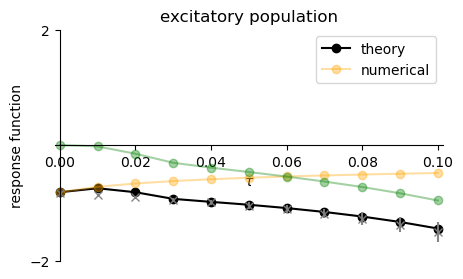

In [16]:
### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_mean[:,0],'k')
ax.plot(tau_series,response_func_contribution[:,0,0],'orange',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,0],'green',alpha=0.36)

# ax.plot(tau_series,response_func_contribution[:,0,0]+response_func_contribution[:,1,0],'green',marker='o')
# ### numerical using filled_between 
# ax.fill_between(tau_series,response_func_num_mean[:,0]+np.nanstd(response_func_num[:,:,:],axis=0)[:,0],response_func_num_mean[:,0]-np.nanstd(response_func_num[:,:,:],axis=0)[:,0],color='k',alpha=0.3)
alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,0],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,0],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('excitatory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
### set yaxis, ylim not too large!
ax.set_ylim([-2,2])
ax.set_yticks([-2,2])
ax.set_xlim([0-dtau/8,tau_series[-1]+dtau/8])

plt.show()

Fig 7(d)

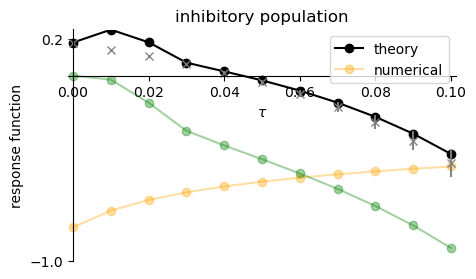

In [17]:

### compare response_func with response7 _func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.mean(response_func_num[:,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_mean[:,1],'k')
# ax.plot(tau_series,np.mean(pureE,axis=0),'r',marker='o')

ax.plot(tau_series,response_func_contribution[:,0,1],'orange',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,1],'green',alpha=0.36)

alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,1],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,1],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)

# ax.fill_between(tau_series,response_func_num_mean[:,1]+np.std(response_func_num[:,:,:],axis=0)[:,1],response_func_num_mean[:,1]-np.std(response_func_num[:,:,:],axis=0)[:,1],color='black',alpha=0.3)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('inhibitory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
### set yaxis, ylim not too large!
ax.set_ylim([-0.5,1.5])

ax.set_yticks([-1.,0.2])
ax.set_ylim([-1.,0.25])
ax.set_xlim([0-dtau/8,tau_series[-1]+dtau/8])

plt.show()

Fig 7 eigenvalues

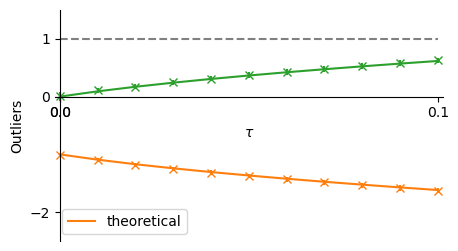

In [18]:
### plot the numerical and theoretical eigenvalues outliers
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(tau_series,eigvchn_theo[:,0],'tab:orange',label='theoretical')
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green')

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='tab:orange',ecolor='tab:orange',alpha=1,ls='',elinewidth=1.5)
ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=1,ls='',elinewidth=1.5)
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]//2,tau_series[-1]])
ax.set_ylim([-2.5,1.5])
ax.set_yticks([-2,0,1])
ax.set_ylim([-4.5,3.5])
ax.set_yticks([-4,0,3])

ax.set_ylim([-2.5,1.5])
ax.set_yticks([-2,0,1])
### plot y==1 
ax.plot([0,tau_series[-1]],[1,1],color='gray',linestyle='--',linewidth=1.5)
ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

#### Excitatory input to excitatory neurons

In [29]:
#### constant and deterministic input signal
Inp   = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
Ipert = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
# Ipert[:NE]=0 ### inhibitory input 
Ipert[NE:]=0 ### excitatory input
#### random and structural input signal 
### simulation using the mean network connectivity (inhibition-dominated)
Jpt   = Jbar.copy()
xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
tt    = np.linspace(0,100,1000)
xtemporal = odesimulation(tt, xinit, Jpt, Inp)
firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))

In [ ]:
data_name ="E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/19Mar_eigenvectors_corrected/Gaussian_data/DynsStats_Gauss_16April_EXParadoxical_normlr.npz"# "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/19Mar_eigenvectors_corrected/Gaussian_data/DynsStats_Gauss_16April_INParadoxical_normlr.npz"#
# np.savez(data_name, **data)
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/19Mar_eigenvectors_corrected/Gaussian_data/DynsStats_Gauss_16April_EXParadoxical_normlr.npz"#DynsStats_Gauss_16April_INParadoxical_normlr.npz"#
### load data  
data = np.load(data_name,allow_pickle=True)
eigvchn_series = data['eigvchn_series']
eigrvec_series = data['eigrvec_series']
eiglvec_series = data['eiglvec_series']
eiglvec0_series = data['eiglvec0_series']
norml0_series = data['norml0_series']
params = data['params']
intg_ov_series = data['intg_ov_series']
first_perturb_ov = data['first_perturb_ov']
first_perturb_ovP = data['first_perturb_ovP']
intg_mean_series = data['intg_mean_series']
intg_std_series = data['intg_std_series']
intg_std_num_series = data['intg_std_num_series']

firing_rateeq = data['firing_rateeq']
firing_ratepert = data['firing_ratepert']

In [30]:
mean_rvec = np.zeros((ntau,2,2))
mean_lvec = np.zeros((ntau,2,2))

for it in range(ntau):
    for ir in range(2):
        for ip in range(2):
            mean_rvec[it,ir,ip] = np.nanmean(mean_reigvec_num_series[:,it,ir,ip])
            mean_lvec[it,ir,ip] = np.nanmean(mean_leigvec_num_series[:,it,ir,ip])*eigvchn_theo[it,ir].real
            
### compute the theoretical response function 
rank = 2
response_func_contribution = np.zeros((ntau,rank,2))

### compute the theoretical response function 
response_func = np.zeros((trials,ntau,2))
for it in range(ntau):
    response_func[:,it,0] = 1
    if it>=0:#1:
        for ir in range(2):
            response_func[:,it,0] += (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,0] = (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)                
    else:
        for ir in range(1):
            response_func[:,it,0] += (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,0] = (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NE*(mean_lvec[it,ir,0])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)



In [31]:
### 
meanfr_eq = np.zeros((trials,ntau,2))
meanfr_pert = np.zeros((trials,ntau,2))
meanfr_eq[:,:,0] = np.mean(firing_rateeq[:,:,:NE],axis=2)
meanfr_eq[:,:,1] = np.mean(firing_rateeq[:,:,NE:],axis=2)
### same for pydll Creates ()
meanfr_pert[:,:,0] = np.mean(firing_ratepert[:,:,:NE],axis=2)
meanfr_pert[:,:,1] = np.mean(firing_ratepert[:,:,NE:],axis=2)
### numerical response function 
response_func_num = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
        response_func_num[ktrial,it,0]=(meanfr_pert[ktrial,it,0]-meanfr_eq[ktrial,it,0])/Ipert[0]#Ipert[-1]
        response_func_num[ktrial,it,1]=(meanfr_pert[ktrial,it,1]-meanfr_eq[ktrial,it,1])/Ipert[0]#Ipert[-1]
        
# #### delete the largest 3 and the smallest 3 from response_func_num
# for it in range(ntau):
#     idxsort = np.where(np.abs(response_func_num[:,it,0].copy())>1e2)
#     idxnan = (idxsort) 
#     response_func_num[idxnan,it,0] = np.nan 
    
    
#     idxsort = np.where(np.abs(response_func_num[:,it,1].copy())>1e2)
#     idxnan = (idxsort) 
#     response_func_num[idxnan,it,1] = np.nan 

In [32]:
### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_mean[:,0],'k')

ax.plot(tau_series,response_func_contribution[:,0,0],'orange',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,0],'green',alpha=0.36)
alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,0],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,0],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('excitatory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
### set yaxis, ylim not too large!
ax.set_ylim([0,3])
ax.set_yticks([0,3])
ax.set_xlim([0-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]])
plt.show()

In [33]:
### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tau_series,response_func_mean[:,1],'k')
ax.plot(tau_series,response_func_contribution[:,0,1],'orange',alpha=0.36)
ax.plot(tau_series,response_func_contribution[:,1,1],'green',alpha=0.36)
alphass = 0.95
ax.errorbar(tau_series[:],response_func_num_mean[:,1],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,1],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('response function')
ax.set_title('inhibitory population')
ax.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
### set yaxis, ylim not too large!
ax.set_ylim([0,3])
ax.set_yticks([0,3])
ax.set_xlim([0-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]])
plt.show()

Save the data

In [ ]:
def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d

In [22]:
params = {'gaverage':gaverage,
          'gamma':gamma,
          'JE':JE,
          'JI':JI,
          'NE':NE,
          'NI':NI,
          'tau_series':tau_series,
          }
lst = [eigvchn_series, eigrvec_series, eiglvec_series,
       eigrvec_series_rec, eiglvec_series_rec,
        eiglvec0_series, norml0_series, params,
        lowrank_eq, firing_rateeq,lowrank_eq_num,firing_ratepert,
        leig0mean_series]
stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
       "eigrvec_series_rec, eiglvec_series_rec,"
        "eiglvec0_series, norml0_series, params,"
        "lowrank_eq, firing_rateeq,lowrank_eq_num,firing_ratepert,"
        "leig0mean_series"]
data = list_to_dict(lst=lst, string=stg)
data_name = "----save the data----"
# np.savez(data_name, **data)